In [1]:
%matplotlib notebook
import utils; reload(utils);
from utils import *
import os
import tensorflow as tf
from __future__ import division, print_function

Using TensorFlow backend.


In [43]:
data_path = "/Users/trinakarmakar/anaconda2/data/fastai/ratings/"
model_path = data_path + 'models/'
if not os.path.exists(data_path):
    os.mkdir(data_path)
    os.mkdir(model_path)

In [3]:
batch_size = 64

In [4]:
import pandas as pd

In [5]:
ratings = pd.read_csv(data_path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

In [7]:
movies = pd.read_csv(data_path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movie_names = pd.read_csv(data_path+'movies.csv').set_index('movieId')['title'].to_dict()

In [9]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [10]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [11]:
ratings.apply(lambda x: movieid2idx[1193])

userId       327
movieId      327
rating       327
timestamp    327
dtype: int64

We want to update the movie and user ids so that they are contagious integres, which we want when using embeddings

In [12]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [13]:
user_min, user_max, movie_min, movie_max = ratings.userId.min(), ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max()
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [14]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [15]:
#set the number of latent featires for embeddings
n_factors = 50

In [16]:
import numpy as np
np.random.seed=42

In [17]:
msk = np.random.rand(len(ratings)) < 0.8
train_data = ratings[msk]
val_data = ratings[~msk]

In [18]:
#The most basic model is dot product of user embeddings and movie embeddings
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  app.launch_new_instance()
/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`


In [19]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [21]:
model.fit([train_data.userId, train_data.movieId], train_data.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val_data.userId, val_data.movieId], val_data.rating))

Train on 79854 samples, validate on 20150 samples
Epoch 1/1
  576/79854 [..............................] - ETA: 25s - loss: 13.9263  192/79854 [..............................] - ETA: 32s - loss: 14.6856

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


79854/79854 [==============================] - 23s - loss: 10.0407 - val_loss: 4.3351  960/79854 [..............................] - ETA: 24s - loss: 14.0850

In [22]:
model.optimizer.lr = .001

In [23]:
model.fit([train_data.userId, train_data.movieId], train_data.rating, batch_size=64, nb_epoch=4, 
          validation_data=([val_data.userId, val_data.movieId], val_data.rating))

Train on 79854 samples, validate on 20150 samples
Epoch 1/4
  448/79854 [..............................] - ETA: 27s - loss: 3.9492  256/79854 [..............................] - ETA: 27s - loss: 3.8917

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


79854/79854 [==============================] - 23s - loss: 3.1741 - val_loss: 2.7863  768/79854 [..............................] - ETA: 28s - loss: 4.0672

We need to add bias for each movie and each user - how each user postive or negative for each movie and how good 
each movie is, we can do that easily by creating an embedding for each user and movie.

In [27]:
def embed_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [28]:
user_in, u = embed_input('n_users', n_users, n_factors, 1e-4)
movie_in, m = embed_input('n_movies', n_movies, n_factors, 1e-4)

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  app.launch_new_instance()
/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  app.launch_new_instance()


In [30]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [31]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [36]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(lr=0.01), loss = 'mse')

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [39]:
model.fit([train_data.userId, train_data.movieId], train_data.rating, batch_size=64, nb_epoch=4,
         validation_data = ([val_data.userId, val_data.movieId], val_data.rating))

Train on 79854 samples, validate on 20150 samples
Epoch 1/4
  576/79854 [..............................] - ETA: 26s - loss: 0.8930  192/79854 [..............................] - ETA: 32s - loss: 0.8824

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


79854/79854 [==============================] - 24s - loss: 0.9813 - val_loss: 1.1991  960/79854 [..............................] - ETA: 25s - loss: 0.8563

In [40]:
model.optimizer.lr = 0.001

In [41]:
model.fit([train_data.userId, train_data.movieId], train_data.rating, batch_size=64, nb_epoch=4,
         validation_data = ([val_data.userId, val_data.movieId], val_data.rating))

Train on 79854 samples, validate on 20150 samples
Epoch 1/4
  448/79854 [..............................] - ETA: 26s - loss: 0.8343  256/79854 [..............................] - ETA: 27s - loss: 0.8353

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


79854/79854 [==============================] - 24s - loss: 0.9442 - val_loss: 1.2000

In [45]:
model.save_weights(model_path+'bias.h5')
model.load_weights(model_path+'bias.h5')

In [47]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7972]], dtype=float32)

In [49]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [52]:
#use keras to get a movie bias by movie id 
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

In [53]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.4194348, 'Howard the Duck (1986)'),
 (-1.3369688, 'Battlefield Earth (2000)'),
 (-1.1270303, 'Police Academy 6: City Under Siege (1989)'),
 (-1.0516353, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-1.0046853, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.98432553, 'Jaws 3-D (1983)'),
 (-0.96958005, 'Super Mario Bros. (1993)'),
 (-0.96043563, 'Spice World (1997)'),
 (-0.94508976, 'Blade: Trinity (2004)'),
 (-0.88764805, 'Avengers, The (1998)'),
 (-0.80654639, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.79903048, 'Anaconda (1997)'),
 (-0.79354662, 'Speed 2: Cruise Control (1997)'),
 (-0.7275635, 'Bio-Dome (1996)'),
 (-0.69035584, 'Nutty Professor II: The Klumps (2000)')]

In [54]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(2.2299833, 'Mister Roberts (1955)'),
 (2.0461042, 'Harvey (1950)'),
 (2.0042334, 'Modern Times (1936)'),
 (1.9242892, 'You Can Count on Me (2000)'),
 (1.8941265, 'Strangers on a Train (1951)'),
 (1.892267, 'Fantastic Mr. Fox (2009)'),
 (1.8863859, 'Ran (1985)'),
 (1.8677449, 'How the Grinch Stole Christmas! (1966)'),
 (1.8644849, 'Rush (2013)'),
 (1.8567141, 'Shadowlands (1993)'),
 (1.8472273, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (1.843677, "All the President's Men (1976)"),
 (1.8421786, 'Big Night (1996)'),
 (1.8419931, 'It Happened One Night (1934)'),
 (1.84149, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)')]

In [56]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

In [57]:
#It is hard to visualize 50 dimension we will use PCA to take 3 dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [58]:
fac0 = movie_pca[0]

In [61]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac0, topMovies)]

In [62]:
sorted(movie_comp, key = itemgetter(0), reverse=True)[:10]

[(0.11394657869648805, 'Clue (1985)'),
 (0.096001775679109752, 'Two Weeks Notice (2002)'),
 (0.094981719674702092, 'Thirteen Days (2000)'),
 (0.094881908321851408, "She's the One (1996)"),
 (0.082778209444996725, 'Star Wars: Episode III - Revenge of the Sith (2005)'),
 (0.081279811507483271, 'Transformers: Revenge of the Fallen (2009)'),
 (0.080910400056334958, 'Transformers (2007)'),
 (0.079267943908978525, 'Father of the Bride (1991)'),
 (0.079122811971356455, 'Bad Santa (2003)'),
 (0.077169880563306939, 'Watchmen (2009)')]

In [63]:
sorted(movie_comp, key = itemgetter(0))[:10] #first is oscar winners

[(-0.1020589990863595, 'Big Hero 6 (2014)'),
 (-0.10204070853344625, 'The Imitation Game (2014)'),
 (-0.088093916251528515, 'Enemy at the Gates (2001)'),
 (-0.086737208140403269, 'Curious Case of Benjamin Button, The (2008)'),
 (-0.085213802656956758, 'Aviator, The (2004)'),
 (-0.083622787761747044, 'Grand Budapest Hotel, The (2014)'),
 (-0.080226009326358205, 'Burn After Reading (2008)'),
 (-0.078709709796088018, 'Name of the Rose, The (Name der Rose, Der) (1986)'),
 (-0.077954821637076038, 'Lucky Number Slevin (2006)'),
 (-0.077889458566576544, 'Payback (1999)')]

In [65]:
fac1 = movie_pca[1]

In [66]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

In [67]:
sorted(movie_comp, key = itemgetter(0), reverse=True)[:10]

[(0.089432031551641158, '2001: A Space Odyssey (1968)'),
 (0.087049443362724327, 'Clockwork Orange, A (1971)'),
 (0.079693758142840673, 'Pulp Fiction (1994)'),
 (0.074578562627001077, 'L.A. Confidential (1997)'),
 (0.070148815401692599, 'Fargo (1996)'),
 (0.066229691349460995, 'Hudsucker Proxy, The (1994)'),
 (0.066174260455677494, 'Seven (a.k.a. Se7en) (1995)'),
 (0.065810686139145647, 'Leaving Las Vegas (1995)'),
 (0.065733853293164585, 'Silence of the Lambs, The (1991)'),
 (0.064349075800181357, 'Taxi Driver (1976)')]

In [68]:
sorted(movie_comp, key = itemgetter(0))[:10] #Hollywood blockbusters

[(-0.097869530450100328, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.081907761992786515, 'Armageddon (1998)'),
 (-0.068983577068738658, 'Scary Movie 3 (2003)'),
 (-0.06878649230057346, 'Stargate (1994)'),
 (-0.068469652620514146, 'Maverick (1994)'),
 (-0.063280171557830306, 'Lethal Weapon 4 (1998)'),
 (-0.063100172509159613, 'Jungle Book, The (1994)'),
 (-0.062852919434247354, 'Titanic (1997)'),
 (-0.062245830234032212, 'Miss Congeniality (2000)'),
 (-0.061691212528875744, 'Planet of the Apes (2001)')]

In [72]:
fac2 = movie_pca[2]

In [73]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac2, topMovies)]

In [74]:
sorted(movie_comp, key = itemgetter(0), reverse=True)[:10]

[(0.11507460860892417, 'Menace II Society (1993)'),
 (0.10263226912941159, 'Stigmata (1999)'),
 (0.10005660889620049, 'Insider, The (1999)'),
 (0.091603300724892991, 'Swingers (1996)'),
 (0.087533394405317419, 'Dances with Wolves (1990)'),
 (0.083959673801035847, 'Right Stuff, The (1983)'),
 (0.083519557743241393, 'Arthur (1981)'),
 (0.083433885409082545, "Schindler's List (1993)"),
 (0.082979379230004521, 'Little Rascals, The (1994)'),
 (0.081922179446722115, 'Muse, The (1999)')]

In [75]:
sorted(movie_comp, key = itemgetter(0))[:10] #violence vs happy

[(-0.11780661885742312, 'How to Make an American Quilt (1995)'),
 (-0.097366132085978496, 'BASEketball (1998)'),
 (-0.093158394482732096, 'Single White Female (1992)'),
 (-0.084053598457741949, 'Mulholland Falls (1996)'),
 (-0.073641309094810675, 'Real Genius (1985)'),
 (-0.071824835287360222, 'Showgirls (1995)'),
 (-0.067525032036979502, 'Sphere (1998)'),
 (-0.061911365193843271, 'Blair Witch Project, The (1999)'),
 (-0.061831941987128582, 'Snake Eyes (1998)'),
 (-0.061463506704810232, 'Ghostbusters (a.k.a. Ghost Busters) (1984)')]

In [77]:
import sys
stdout, stderr = sys.stdout, sys.stderr #save notebook stderr and stdout
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdout, sys.stderr = stdout, stderr #restore notebook stderr and stdout

<IPython.core.display.Javascript object>


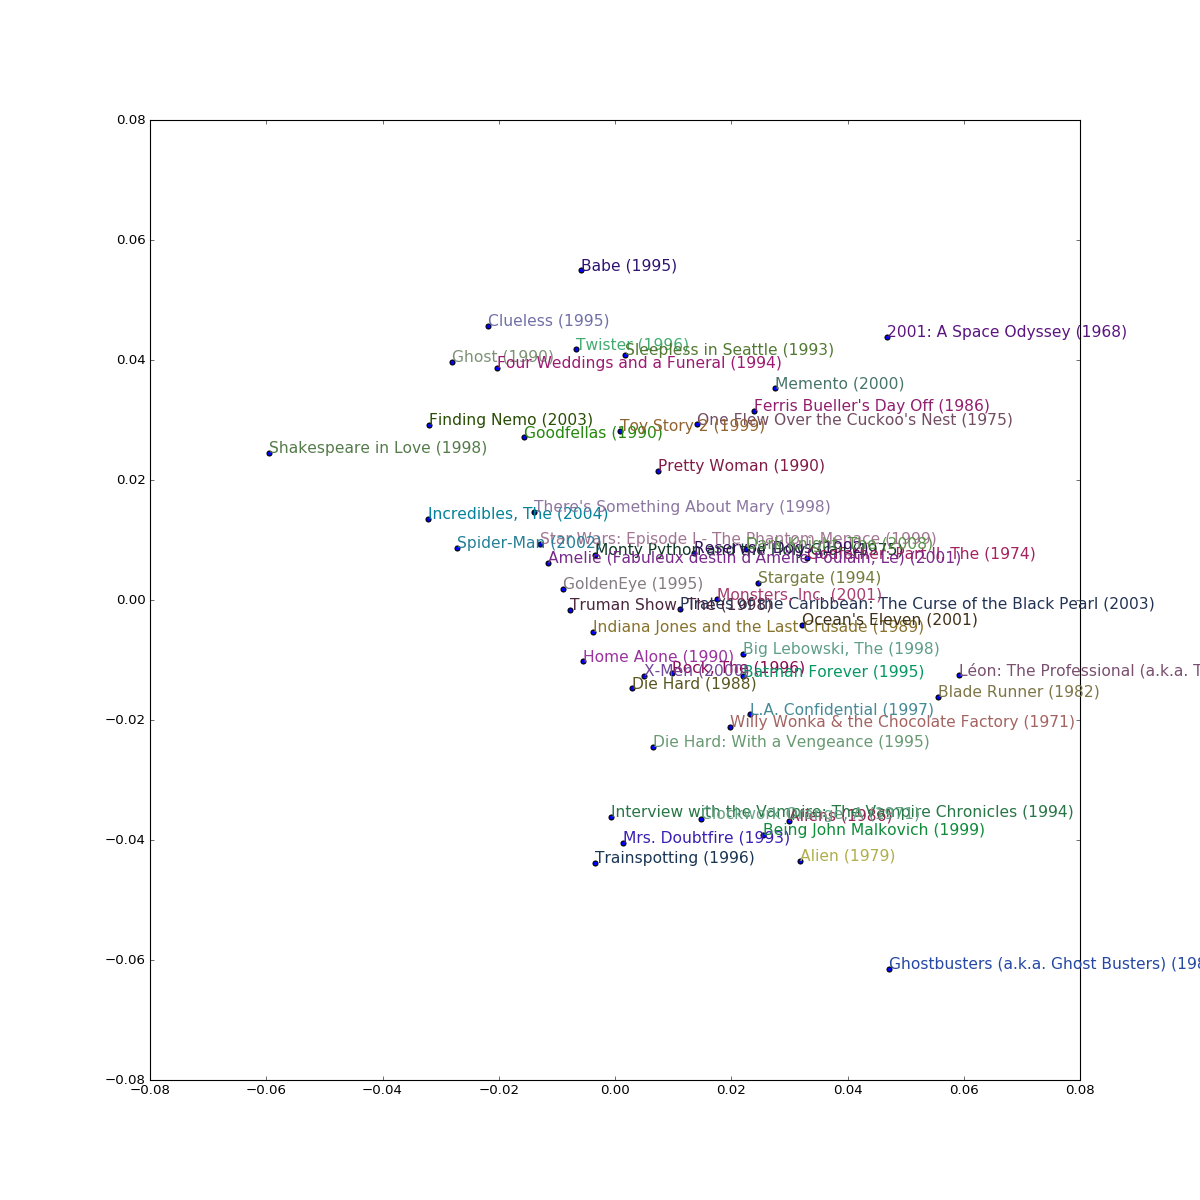

In [80]:
start=50 
end=100
x = fac0[start:end]
y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(x,y)
for i, x, y in zip(topMovies[start:end], x, y):
    plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3)*.7, fontsize=14)
plt.show()

## Neural Net

In [84]:
user_in, u = embed_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embed_input('movie_in', n_movies, n_factors, 1e-4)

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  app.launch_new_instance()
/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  app.launch_new_instance()


In [86]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
neural_model = Model([user_in, movie_in], x)
neural_model.compile(Adam(0.001), loss='mse')

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':


In [ ]:
neural_model.fit([train_data.userId, train_data.movieId], train_data.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val_data.userId, val_data.movieId], val_data.rating))

/Users/trinakarmakar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 79854 samples, validate on 20150 samples
Epoch 1/8
79854/79854 [==============================] - 26s - loss: 2.4321 - val_loss: 0.9022